# Image approximation with geometrical shapes

This notebook shows how grammar-guided genetic programming (G3P) can be used for a task invented by Roger Johansson: search for a configuration of semi-transparent geoemetrical shapes, so that the resulting image closely resembles a given target image.

Note that it requires the library pillow to draw images. It can be installed with `pip install pillow`.

## References

- [Roger Johansson: Evolution of Mona Lisa](https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/)

In [1]:
import time

import alogos as al
import IPython
from PIL import Image, ImageDraw, ImageChops, ImageStat

## Preparation

### 1) Functions for handling images

In [2]:
def load_image_from_file(filepath):
    return Image.open(filepath).convert('RGB')

def store_image_to_file(img, filepath):
    img.save(filepath)

def store_string_to_file(img, filepath):
    with open(filepath, 'w') as f:
        f.write(string)

def resize_image(img, width):
    w, h = img.size
    height = int(width * h / w)
    return img.resize((width, height), Image.Resampling.LANCZOS)

def display_image(img):
    IPython.display.display(img)

### 2) Functions for drawing shapes

In [3]:
def create_image(width, height, bg_color='black'):
    return Image.new('RGB', (width, height), bg_color)

def create_drawer(img):
    return ImageDraw.Draw(img, 'RGBA')

def circle(d, x, y, r, c):
    d.ellipse(((x-r, y-r), (x+r, y+r)), c)

def ellipse(d, p, c):
    d.ellipse(p, c)

def triangle(d, p, c):
    d.polygon(p, c)

def quadrilateral(d, p, c):
    d.polygon(p, c)

def pentagon(d, p, c):
    d.polygon(p, c)

def hexagon(d, p, c):
    d.polygon(p, c)

def heptagon(d, p, c):
    d.polygon(p, c)

def octagon(d, p, c):
    d.polygon(p, c)

def nonagon(d, p, c):
    d.polygon(p, c)
    
def polygon(d, p, c):
    d.polygon(p, c)

### 3) Target image

In [4]:
img_name = 'mona_lisa'
img_ori = load_image_from_file(img_name + '.png')

# smaller image size leads to much faster objective function evaluation
size = 70
img_target = resize_image(img_ori, size)

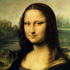

In [5]:
display_image(img_target)

## Definition of search space and goal

### 1) Grammar

This grammar defines the search space: a Python program that creates an empty image and draws a chosen number and type of geometrical shapes on it, with locations and colors being variable.

In [6]:
ebnf_template = """
PROGRAM = IMAGE NL DRAWER NL SHAPES

IMAGE = "im = create_image(w, h)"
DRAWER = "d = create_drawer(im)"
SHAPES = {chosen_number}

SHAPE = {chosen_shapes}
CIRC = "circle(d, " X "," Y "," R "," C ")"
ELLI = "ellipse(d,(" PT "," PT ")," C ")"
TRI = "triangle(d,(" PT "," PT "," PT ")," C ")"
QUAD = "quadrilateral(d,(" PT "," PT "," PT "," PT ")," C ")"
PENT = "pentagon(d,(" PT "," PT "," PT "," PT "," PT ")," C ")"
HEX = "hexagon(d,(" PT "," PT "," PT "," PT "," PT "," PT ")," C ")"
HEPT = "heptagon(d,(" PT "," PT "," PT "," PT "," PT "," PT "," PT ")," C ")"
OCT = "octagon(d,(" PT "," PT "," PT "," PT "," PT "," PT "," PT "," PT ")," C ")"
NONA = "nonagon(d,(" PT "," PT "," PT "," PT "," PT "," PT "," PT "," PT "," PT ")," C ")"
POLY = "polygon(d,(" POINTS ")," C ")"

POINTS = PT "," PT | POINTS "," PT
PT = X "," Y
X = FRAC "*w"
Y = FRAC "*h"
R = FRAC "*w/2"
C = "(" INT "," INT "," INT ", {chosen_alpha})"

FRAC = "0." DIG DIG
INT = "int(" FRAC "*255)"
DIG = "0" | "1" | "2" | "3" | "4" | "5" | "6" | "7" | "8" | "9"
NL = "\n"
"""


def generate_grammar(num_shapes=150, shapes='CIRC | ELLI | TRI | QUAD | PENT | POLY', alpha=50):
    """Parameterized generation of the grammar: Choose number and type of drawn shapes."""
    ebnf_text = ebnf_template.format(
        chosen_number='SHAPE NL '*num_shapes, chosen_shapes=shapes, chosen_alpha=alpha)
    grammar = al.Grammar(ebnf_text=ebnf_text)
    return grammar


grammar = generate_grammar(50, 'NONA')

### 2) Objective function

The objective function gets a candidate solution (=a string of the grammar's language) and returns a fitness value for it. This is done by 1) executing the string as a Python program, so that it draws a candidate image, and then 2) pixel-wise comparing the candidate image with the target image: the smaller the difference, the better is the candidate.

In [7]:
w, h = img_target.size

var = dict(
    w=w,
    h=h,
    create_image=create_image,
    create_drawer=create_drawer,
    circle=circle,
    ellipse=ellipse,
    triangle=triangle,
    quadrilateral=quadrilateral,
    pentagon=pentagon,
    hexagon=hexagon,
    heptagon=heptagon,
    octagon=octagon,
    nonagon=nonagon,
    polygon=polygon,
)

var_large = var.copy()
var_large['w'] = 500
var_large['h'] = 500

In [8]:
def run_python_code(string, var=var):
    exec(string, var)
    return var['im']

In [9]:
def px_diff(im1, im2):
    return sum(ImageStat.Stat(ImageChops.difference(im1, im2)).sum)

In [10]:
def objective_function(string):
    img = run_python_code(string)
    return px_diff(img, img_target)

## Generation of a random solution

Check if grammar and objective function work as intended.

A random string:
im = create_image(w, h)
d = create_drawer(im)
nonagon(d,(0.18*w,0.80*h,0.70*w,0.72*h,0.54*w,0.00*h,0.45*w,0.92*h,0.17*w,0.38*h,0.35*w,0.09*h,0.15*w,0.97*h,0.15*w,0.09*h,0.31*w,0.32*h),(int(0.52*255),int(0.00*255),int(0.77*255), 50))
nonagon(d,(0.48*w,0.53*h,0.67*w,0.40*h,0.97*w,0.46*h,0.70*w,0.69*h,0.37*w,0.52*h,0.68*w,0.49*h,0.20*w,0.95*h,0.00*w,0.26*h,0.09*w,0.67*h),(int(0.09*255),int(0.54*255),int(0.36*255), 50))
nonagon(d,(0.64*w,0.45*h,0.50*w,0.71*h,0.60*w,0.16*h,0.95*w,0.84*h,0.00*w,0.43*h .........

Visualized:


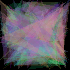


Fitness value assigned by the objective function: 1166740.0


In [11]:
random_string = grammar.generate_string()
print('A random string:')
print(random_string[:500], '.........')

print()
print('Visualized:')
img = run_python_code(random_string)
display_image(img)

print()
print('Fitness value assigned by the objective function:', objective_function(random_string))

## Search for an optimal solution

Evolutionary optimization with random variation and non-random selection is used to find increasingly better candidate solutions.

### 1) Parameterization

In [12]:
report_time = True
display_results = True
store_results = False

num_ind = 2
num_gen = 25_000

In [13]:
ea = al.EvolutionaryAlgorithm(
    grammar, objective_function, 'min', population_size=num_ind, offspring_size=num_ind)

### 2) Run

The search is performed one generation after another and some intermediate results are reported to see how the solutions improve gradually.

1000: 0min 13s


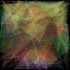

2000: 0min 24s


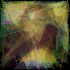

3000: 0min 35s


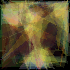

4000: 0min 46s


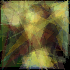

5000: 0min 57s


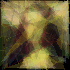

6000: 1min 8s


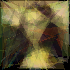

7000: 1min 19s


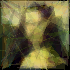

8000: 1min 30s


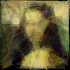

9000: 1min 41s


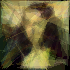

10000: 1min 53s


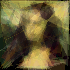

11000: 2min 4s


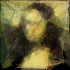

12000: 2min 15s


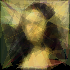

13000: 2min 26s


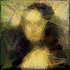

14000: 2min 38s


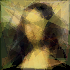

15000: 2min 49s


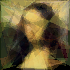

16000: 2min 60s


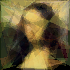

17000: 3min 11s


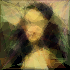

18000: 3min 22s


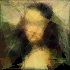

19000: 3min 33s


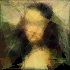

20000: 3min 45s


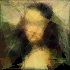

21000: 3min 56s


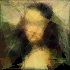

22000: 4min 7s


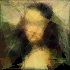

23000: 4min 19s


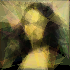

24000: 4min 30s


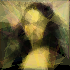

25000: 4min 42s


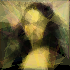

In [14]:
start = time.time()
for i in range(1, num_gen+1):
    best_ind = ea.step()

    if i % 1000 == 0:
        string = best_ind.phenotype

        if report_time:
            dt = time.time() - start
            print('{}: {:.0f}min {:.0f}s'.format(i, dt // 60, dt % 60))

        if display_results:
            img = run_python_code(string)
            display_image(img)

        if store_results:
            img = run_python_code(string, var_large)
            store_image_to_file(img, 'results/{}_n{}_s{}_g{}.png'.format(img_name, args[0], args[1], i))
            store_string_to_file(string, 'results/{}_n{}_s{}_g{}.txt'.format(img_name, args[0], args[1], i))

### 3) Result

Show the phenotype of the best individual found so far. If more computing time is provided, increasingly better solutions can be found.

Preliminary result after 25000 generations


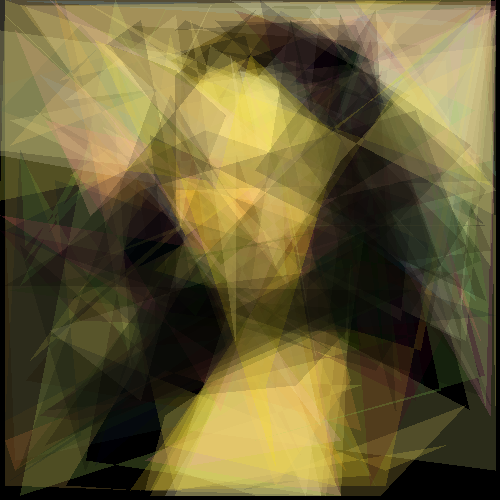

In [15]:
print('Preliminary result after {} generations'.format(ea.state.generation))

string = best_ind.phenotype
img = run_python_code(string, var_large)
display_image(img)